This is an analysis of the 2025 clock data. The data collected on 2025-03-13 has a subfolder with data that seems to be formatted differently from the rest. 

In [4]:
# import sys
# print(sys.executable)

In [5]:
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
import math 
import missingno as msno
from astropy.time import Time

################################################################################
#############################  Load data #######################################
################################################################################

## comb data (note last two columns swapped from earlier code, also not including header varb in function) 
def open_ErYb_data(data_path):
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Yb_ErYb", "fb_Al_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    data.index = range(len(data))
 
    return data[list(types.keys())]

## Al shift data 
def open_shiftfile_Al(datapath):
    data = pd.read_csv(datapath, header=30, delimiter="\t", dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data

## Sr shift data (note header is 24 lines) 
def open_shiftfile_Sr(datapath):
    data = pd.read_csv(datapath, header=24, delimiter="\t", dtype={1: str}, engine="python")

    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
 ## Yb shift data (note use of raw string deliminator is necessary here probably due to data coming from a json config file or something about the string construction of the data file)  
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t",  dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
## Open maser correction file 
def open_maser_correction(datapath):
    data = pd.read_csv(datapath, header=1, delimiter=",", dtype={1: str}, engine="python")
 
    data.columns = ["date", "maser_offset"]
 
    data["date"] = data["date"].str.split("-").str.join("")
    data["maser_offset"] = data["maser_offset"].apply(float)
 
    return data

In [6]:

## Dates for which we have complete 2025 data. 
day_index = 4
#days = [20250116, 20250124, 20250204, 20250206, 20250227, 20250228, 20250304, 20250306, 20250307, 20250313, 20250318, 20250320, 20250321]
days = [20250116, 20250124, 20250204, 20250227, 20250304, 20250307, 20250318]
days = list(map(str, days))
path = "/Users/smt3/Documents/GitHub/2025 clock comparison data/"

maser_corrections = open_maser_correction(path + "daily maser offsets.csv")
#print(maser_corrections["date"])

# load comb data
data_ErYb = open_ErYb_data(path + days[day_index] + "/" + days[day_index] + "_Deglitched_ErYb_only.dat")
 
# load Al shift data 
shift_data_Al = open_shiftfile_Al(path + days[day_index] + "/" + days[day_index] + "_Alp_Freq_Shifts_ErYb.dat")

# load Sr shift data 
shift_data_Sr = open_shiftfile_Sr(path + days[day_index] + "/" + days[day_index] + "_clock_lock0.dat")

# load Yb shift data
shift_data_Yb = open_shiftfile_Yb(path + days[day_index] + "/YbI_1_rerun.txt")

################################################################################
#############  Functions to find optical frequencies with comb equation ########
################################################################################
 
# frequency for Al+ clock
def compute_nuAl_ErYb(data):
    data["nuAl"] = -Decimal("105e6") + Decimal("560444") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Al_ErYb"]
    data["nuAl"] = Decimal(4) * data["nuAl"]   

# frequency for Sr clock 
def compute_nuSr_ErYb(data):
    data["nuSi"] = -Decimal("105e6") + Decimal("388752") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - Decimal("100e6")
    data["nuSr"] = (Decimal("1716882") / Decimal("777577")) * (data["nuSi"] - Decimal("216e6"))

# freuency for Yb clock
def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"] 


################################################################################
###############  get optical frequencies #############################
################################################################################
 
compute_nuAl_ErYb(data_ErYb)
compute_nuSr_ErYb(data_ErYb)
compute_nuYb_ErYb(data_ErYb) 


In [7]:
# Ratios from 2020
YbSrRatio2020 = Decimal("1.2075070393433378482") 
AlYbRatio2020 = Decimal("2.162887127516663703")
AlSrRatio2020 = Decimal("2.611701431781463025")
 
# frequency corrections 
correction_condition = days[day_index] == maser_corrections["date"]
masercorrection = maser_corrections[correction_condition]["maser_offset"].apply(Decimal)

GR_shift_Al = Decimal("-8.114e-16") ##update? ##TODO: update these values based on Drive folder, ask Mason Marshall about missing Al+ GR shift
GR_shift_Yb = Decimal("-8.109e-16")
GR_shift_Sr = Decimal("10.660e-16")
GR_shift_sea_level = Decimal("-1798.501e-16")

total_correction_Yb = Decimal("1") + GR_shift_Yb + GR_shift_sea_level + masercorrection
total_correction_Sr = Decimal("1") + GR_shift_Sr + GR_shift_sea_level + masercorrection
total_correction_Al = Decimal("1") + GR_shift_Al + GR_shift_sea_level + masercorrection


### Overlapping AVAR function 
## Also see: https://pypi.org/project/AllanTools/
def overlapping_avar_fn(y, m): #note y must be a scalar 
    M = len(y)

    if M < 2 * m:
        raise ValueError(f"Length of input (M={M}) must be at least 2 * m (2 * {m} = {2 * m})")

    if any(isinstance(v, Decimal) and v.is_nan() for v in y): #note: is_nan() is used to accomodate list data of type Decimal
        raise ValueError("Input y contains NaN values.")
    
    if m <= 0:
        raise ValueError("m must be a positive integer")

    outer_sum = 0

    for j in range(0, M - 2 * m + 1):
        inner_sum = 0
        for i in range(j, j + m):
            inner_sum += y[i + m] - y[i]
        outer_sum += inner_sum ** 2

    result = outer_sum / (2 * m**2 * (M - 2 * m + 1))
    return result


Missing Al comb nu:  32
Missing Sr comb nu:  32
Missing Yb comb nu:  42


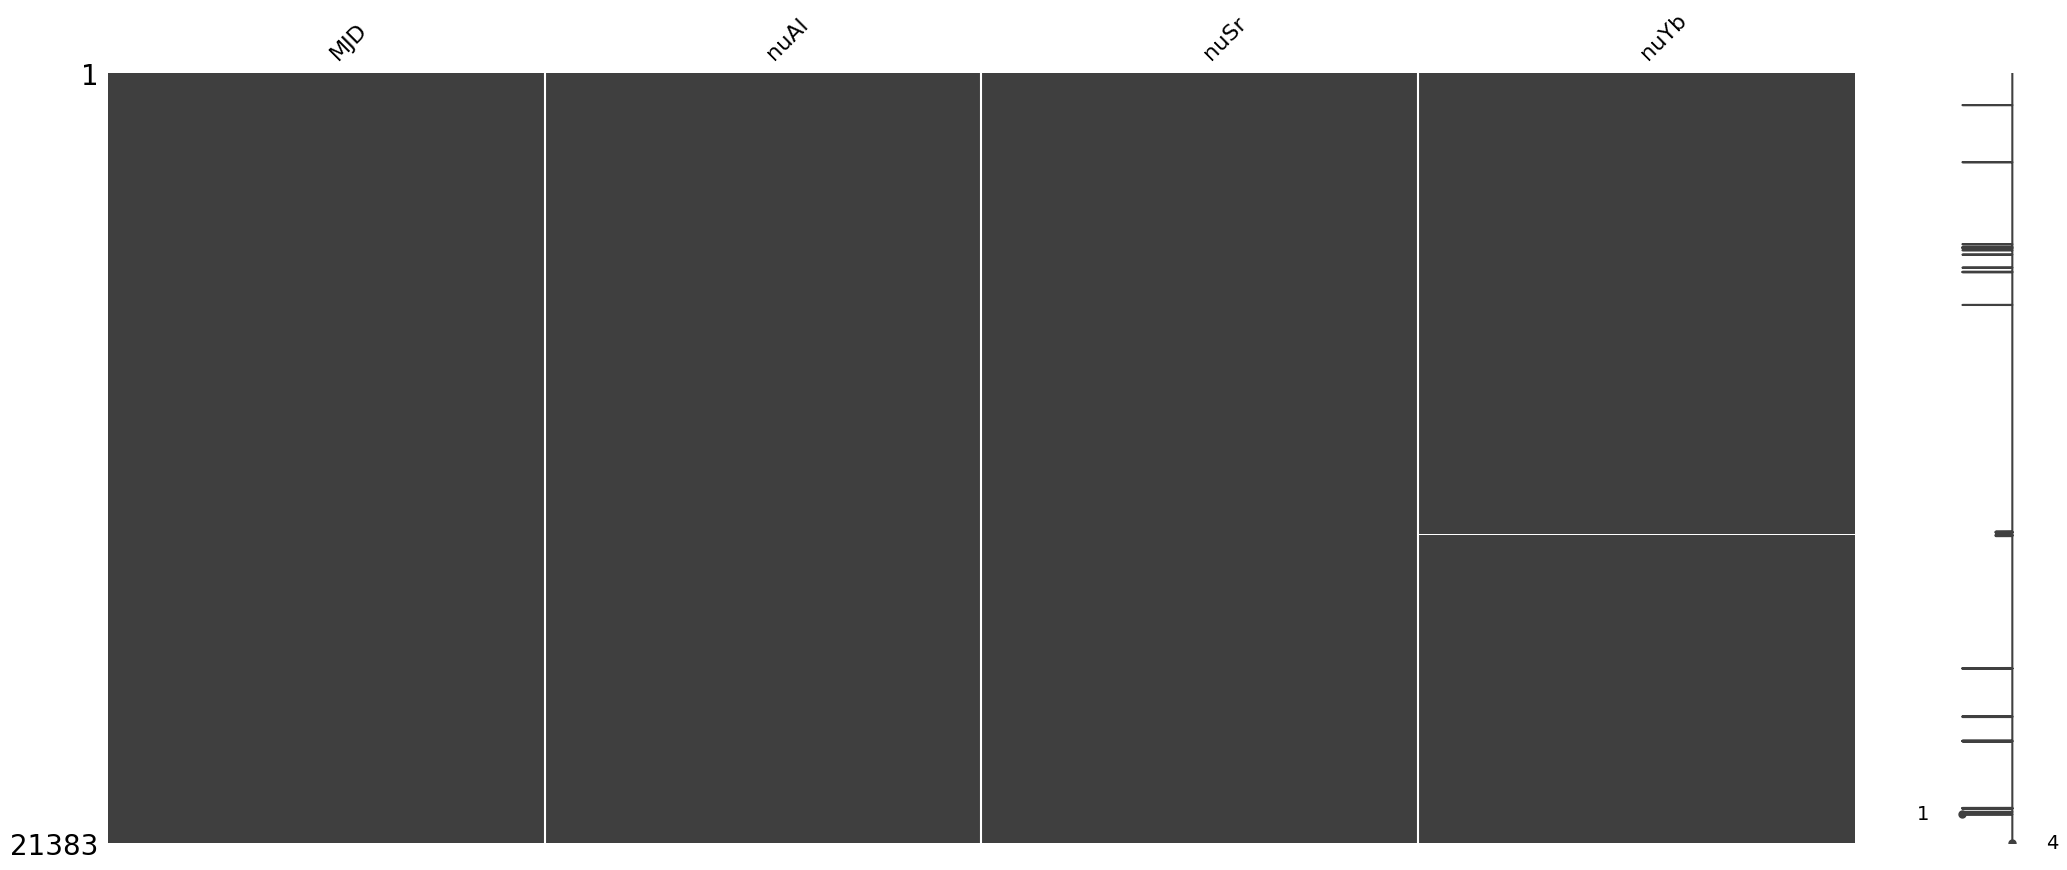

Total NaNs:  42
Longest sequence of NaNs: 2 



In [8]:

################################################################################
#########################  Visualize missing data  #############################
################################################################################

## Visualize missing comb data 
common_mjd = data_ErYb["MJD"].astype(float)
nuAl = data_ErYb["nuAl"].astype(float)
nuSr = data_ErYb["nuSr"].astype(float)
nuYb = data_ErYb['nuYb'].astype(float)

print("Missing Al comb nu: ", nuAl.isna().sum())
print("Missing Sr comb nu: ", nuSr.isna().sum())
print("Missing Yb comb nu: ", nuYb.isna().sum())

msno.matrix(pd.DataFrame({'MJD': common_mjd, 'nuAl': nuAl, 'nuSr': nuSr, 'nuYb': nuYb}))
plt.show()

comb_miss_dict = {'nuAl_miss': nuAl.isna().sum(), 'nuSr_miss': nuSr.isna().sum(), 'nuYb_miss': nuYb.isna().sum()}
if max(comb_miss_dict) == 'nuAl_miss':
    is_na = nuAl.isna()
elif max(comb_miss_dict) == 'nuSr_miss':
    is_na = nuSr.isna()
elif max(comb_miss_dict) == 'nuYb_miss':
    is_na = nuYb.isna()

max_streak_comb = current_streak_comb = 0
for val in is_na:
    if val:
        current_streak_comb += 1
        max_streak_comb = max(max_streak_comb, current_streak_comb)
    else:
        current_streak_comb = 0
print("Total NaNs: ", is_na.sum())
print("Longest sequence of NaNs:", max_streak_comb, '\n')


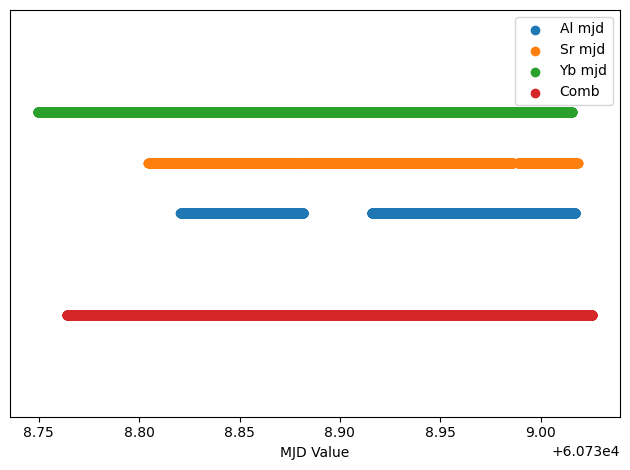

NA Al shift values:  72377
NA Sr shift values:  0
NA Yb shift values:  1770


In [9]:

## Visualize overlapping MJD values of shift data 
## for non-missing shift values 
al_cond = ~shift_data_Al['shift'].isna()
Al_non_na = shift_data_Al[al_cond]
Al = pd.Series(Al_non_na['MJD'])
sr_cond = ~shift_data_Sr['shift'].isna()
Sr_non_na = shift_data_Sr[sr_cond]
Sr = pd.Series(Sr_non_na['MJD'])
yb_cond = ~shift_data_Yb['shift'].isna()
Yb_non_na = shift_data_Yb[yb_cond]
Yb = pd.Series(Yb_non_na['MJD']) 

plt.figure()
plt.scatter(Al, pd.Series([1] * len(Al)), label = 'Al mjd')
plt.scatter(Sr, pd.Series([1.25] * len(Sr)), label = 'Sr mjd')
plt.scatter(Yb, pd.Series([1.5] * len(Yb)), label = 'Yb mjd')
plt.scatter(pd.Series(common_mjd), pd.Series([0.5] * len(pd.Series(common_mjd))), label = 'Comb')
plt.ylim(0,2)
plt.yticks([])
plt.xlabel("MJD Value")
plt.legend()
plt.tight_layout()
plt.show()

## Plot missing shift values for each clock  
print("NA Al shift values: ", shift_data_Al['shift'].isna().sum())
print("NA Sr shift values: ", shift_data_Sr['shift'].isna().sum())
print("NA Yb shift values: ", shift_data_Yb['shift'].isna().sum())


# msno.matrix(pd.DataFrame({'MJD': shift_data_Al['MJD'], 'AL shift': shift_data_Al['shift']}))
# plt.show()

# msno.matrix(pd.DataFrame({'MJD': shift_data_Sr['MJD'], 'Sr shift': shift_data_Sr['shift']}))
# plt.show()

# msno.matrix(pd.DataFrame({'MJD': shift_data_Yb['MJD'], 'Yb shift': shift_data_Yb['shift']}))
# plt.show()


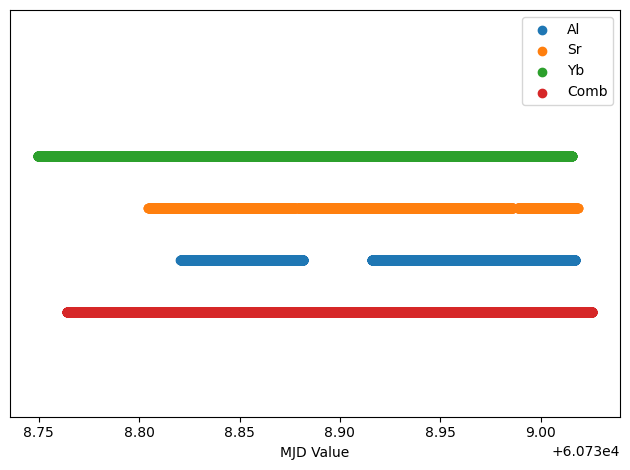

NA Al shift values:  0
NA Sr shift values:  0
NA Yb shift values:  0


In [10]:
## Extract only "IS_GOOD" data for analysis 
good_condition_al = shift_data_Al["IS_GOOD"] == 1
shift_data_Al_good = shift_data_Al[good_condition_al].reset_index(drop=True)
good_condition_sr = shift_data_Sr["IS_GOOD"] == 1
shift_data_Sr_good = shift_data_Sr[good_condition_sr].reset_index(drop=True)
good_condition_yb = shift_data_Yb["IS_GOOD"] == 1
shift_data_Yb_good = shift_data_Yb[good_condition_yb].reset_index(drop=True)

## Visualize overlapping MJD values of  "good" shift data 
Al_good = pd.Series(shift_data_Al_good['MJD'])
Sr_good = pd.Series(shift_data_Sr_good['MJD'])
Yb_good = pd.Series(shift_data_Yb_good['MJD']) 

plt.figure()
plt.scatter(Al_good, pd.Series([1] * len(Al_good)), label = 'Al')
plt.scatter(Sr_good, pd.Series([1.25] * len(Sr_good)), label = 'Sr')
plt.scatter(Yb_good, pd.Series([1.5] * len(Yb_good)), label = 'Yb')
plt.scatter(pd.Series(common_mjd), pd.Series([0.75] * len(pd.Series(common_mjd))), label = 'Comb')
plt.ylim(0.25,2.2)
plt.yticks([])
plt.xlabel("MJD Value")
plt.legend()
plt.tight_layout()
plt.show()

## Visualize missing shift values for each clock's "good" data   
print("NA Al shift values: ", shift_data_Al_good['shift'].isna().sum())
print("NA Sr shift values: ", shift_data_Sr_good['shift'].isna().sum())
print("NA Yb shift values: ", shift_data_Yb_good['shift'].isna().sum())

In [11]:
################################################################################
#############################  Extract overlapping data  #######################
################################################################################
len_comb = len(common_mjd) 
len_Al = len(shift_data_Al_good['shift'])        
len_Sr = len(shift_data_Sr_good['shift'])        
len_Yb = len(shift_data_Yb_good['shift'])

print("nuAl, nuSr, and nuYb start and end MJD: [", common_mjd[0], ', ', common_mjd[len_comb-1], ']')
print("Al good shift start and end MJD: [", shift_data_Al_good['MJD'][0], ', ', shift_data_Al_good['MJD'][len_Al-1], ']')
print("Sr good shift start and end MJD: [", shift_data_Sr_good['MJD'][0], ', ', shift_data_Sr_good['MJD'][len_Sr-1], ']')
print("Yb good shift start and end MJD: [", shift_data_Yb_good['MJD'][0], ', ', shift_data_Yb_good['MJD'][len_Yb-1], ']')

starts = [common_mjd[0], shift_data_Al_good['MJD'][0], shift_data_Sr_good['MJD'][0], shift_data_Yb_good['MJD'][0]] 
ends = [common_mjd[len_comb-1], shift_data_Al_good['MJD'][len_Al-1], shift_data_Sr_good['MJD'][len_Sr-1], shift_data_Yb_good['MJD'][len_Yb-1]] 

last_start_time = max(starts)
first_end_time = min(ends)

#print(last_start_time)
#print(first_end_time)

#function to extract element as close to target as possible w/out going over
#if first element of data is larger or equal to the target, returns the first data index 
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data[inx] < target:
            inx += 1
        else:
            return inx  

#function to extract element as close to target as possible w/out going under 
#if last element of data is smaller or equal to the target, returns the last data index 
def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data[len(data)-inx] > target:
            inx += 1
        else:
            return len(data)-inx 


comb = pd.DataFrame()
comb_start = ub_extract(target = last_start_time, data = common_mjd)  
comb_end = lb_extract(target = first_end_time, data = common_mjd) 

#print(common_mjd[comb_start])
#print(common_mjd[comb_end])

comb["MJD"] = common_mjd[comb_start:comb_end] 
comb["nuAl"] = nuAl[comb_start:comb_end]
comb['nuAl'] = pd.to_numeric(comb['nuAl'], errors='coerce')
comb["nuSr"] = nuSr[comb_start:comb_end]
comb['nuSr'] = pd.to_numeric(comb['nuSr'], errors='coerce')
comb["nuYb"] = nuYb[comb_start:comb_end]
comb['nuYb'] = pd.to_numeric(comb['nuYb'], errors='coerce')

al_start = ub_extract(target = last_start_time, data = shift_data_Al_good["MJD"])
al_end = lb_extract(target = first_end_time, data = shift_data_Al_good["MJD"])  
shift_data_Al = shift_data_Al_good[al_start:al_end] 

sr_start = ub_extract(target = last_start_time, data = shift_data_Sr_good["MJD"])
sr_end = lb_extract(target = first_end_time, data = shift_data_Sr_good["MJD"])  
shift_data_Sr = shift_data_Sr_good[sr_start:sr_end]

yb_start = ub_extract(target = last_start_time, data = shift_data_Yb_good["MJD"])
yb_end = lb_extract(target = first_end_time, data = shift_data_Yb_good["MJD"])  
shift_data_Yb = shift_data_Yb_good[yb_start:yb_end]

nuAl, nuSr, and nuYb start and end MJD: [ 60738.764119 ,  60739.025686 ]
Al good shift start and end MJD: [ 60738.8206019 ,  60739.0171412 ]
Sr good shift start and end MJD: [ 60738.80439413155 ,  60739.01857040927 ]
Yb good shift start and end MJD: [ 60738.74950488 ,  60739.01545343 ]


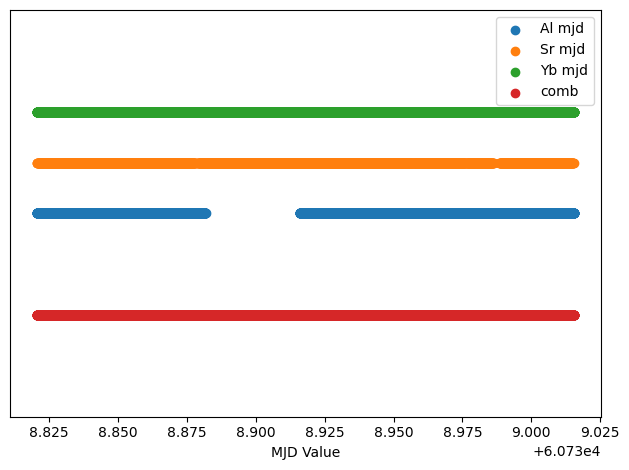

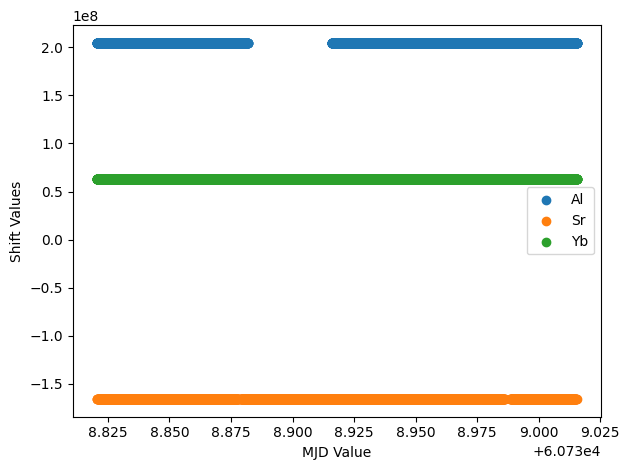

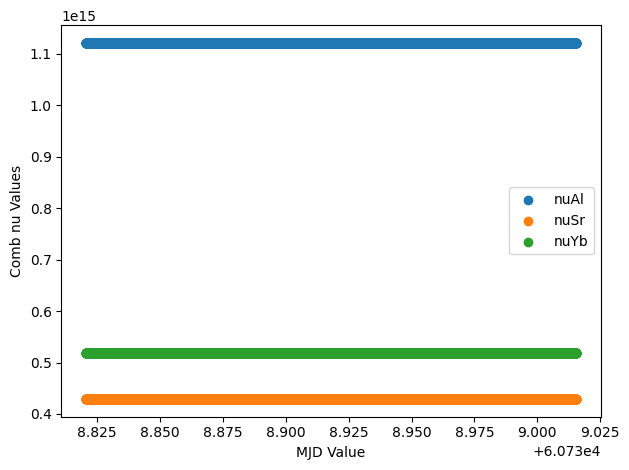

In [12]:
## Visualize overlapping MJD values for subset data and missing shift values w/in this window of overlap

plt.figure()
plt.scatter(shift_data_Al['MJD'], pd.Series([1] * len(shift_data_Al['MJD'])), label = 'Al mjd')
plt.scatter(shift_data_Sr['MJD'], pd.Series([1.25] * len(shift_data_Sr['MJD'])), label = 'Sr mjd')
plt.scatter(shift_data_Yb['MJD'], pd.Series([1.5] * len(shift_data_Yb['MJD'])), label = 'Yb mjd')
plt.scatter(comb['MJD'], pd.Series([0.5] * len(comb['MJD'])), label = 'comb')
plt.ylim(0,2)
plt.yticks([])
plt.xlabel("MJD Value")
plt.legend()
plt.tight_layout()
plt.show()

# msno.matrix(pd.DataFrame({'MJD': comb['MJD'], 'AL shift': shift_data_Al['shift'],
#                           'Sr shift': shift_data_Sr['shift'], 'Yb shift': shift_data_Yb['shift']}))
# plt.show()

# msno.matrix(pd.DataFrame({'MJD': comb['MJD'], 'nuAl': comb['nuAl'],ZZ
#                           'nuSr': comb['nuSr'], 'nuYb': comb['nuYb']}))
# plt.show()

plt.figure()
plt.scatter(shift_data_Al['MJD'], shift_data_Al['shift'], label = 'Al')
plt.scatter(shift_data_Sr['MJD'], shift_data_Sr['shift'], label = 'Sr')
plt.scatter(shift_data_Yb['MJD'], shift_data_Yb['shift'], label = 'Yb')
plt.xlabel("MJD Value")
plt.ylabel("Shift Values")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(comb['MJD'], comb['nuAl'], label = 'nuAl')
plt.scatter(comb['MJD'], comb['nuSr'], label = 'nuSr')
plt.scatter(comb['MJD'], comb['nuYb'], label = 'nuYb')
plt.xlabel("MJD Value")
plt.ylabel("Comb nu Values")
plt.legend()
plt.tight_layout()
plt.show()



In [13]:
################################################################################
##############  Reformat Data for Interpolation  ###############################
################################################################################ 
## Data 
# the shift data frames are: shift_data_Al, shift_Data_Sr, and shift_data_Yb with columns: MJD, shift, is_good
# comb is dataframe with columns MJD, nuAl, nuSr, and nuYb

## Reformat all data so is indexed by datetime 
comb_datetime = comb.copy()
comb_datetime['datetime'] = Time(comb_datetime['MJD'], format = 'mjd').to_datetime()
comb_datetime = comb_datetime.set_index('datetime')

shift_data_Al_datetime = shift_data_Al.copy()
shift_data_Al_datetime['datetime'] = Time(shift_data_Al_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Al_datetime = shift_data_Al_datetime.set_index('datetime')

shift_data_Sr_datetime = shift_data_Sr.copy()
shift_data_Sr_datetime['datetime'] = Time(shift_data_Sr_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Sr_datetime = shift_data_Sr_datetime.set_index('datetime')

shift_data_Yb_datetime = shift_data_Yb.copy()
shift_data_Yb_datetime['datetime'] = Time(shift_data_Yb_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Yb_datetime = shift_data_Yb_datetime.set_index('datetime')

# Eliminate all columns except shift and keep datetime index
Al_shift = shift_data_Al_datetime['shift']
Sr_shift = shift_data_Sr_datetime['shift']
Yb_shift = shift_data_Yb_datetime['shift']

In [14]:
################################################################################
#############################  Interpolation  ##################################
################################################################################ 

interp_method = 'from_derivatives' #'time' 'linear' 'cubic' 

# these are indicies that comb has but Al shift file does not 
interp_times_Al = comb_datetime.index.difference(Al_shift.index) 
# this is the union with the original Al shift indices 
long_Al_index = Al_shift.index.union(interp_times_Al).sort_values()
# this is the expanded Al shift time series that includes NaNs for indicies only in comb data 
Al_shift_expanded = Al_shift.reindex(long_Al_index)
# interpolate the missing Al shift values 
Al_shift_interpolated = Al_shift_expanded.interpolate(method=interp_method, limit=10)
# extract the shift values corresponding to the datetime indicies of the comb data 
Al_shift_final = Al_shift_interpolated[comb_datetime.index]

interp_times_Sr = comb_datetime.index.difference(Sr_shift.index) 
long_Sr_index = Sr_shift.index.union(interp_times_Sr).sort_values()
Sr_shift_expanded = Sr_shift.reindex(long_Sr_index)
Sr_shift_interpolated = Sr_shift_expanded.interpolate(method=interp_method, limit=10)
Sr_shift_final = Sr_shift_interpolated[comb_datetime.index]

interp_times_Yb = comb_datetime.index.difference(Yb_shift.index) 
long_Yb_index = Yb_shift.index.union(interp_times_Yb).sort_values()
Yb_shift_expanded = Yb_shift.reindex(long_Yb_index)
Yb_shift_interpolated = Yb_shift_expanded.interpolate(method=interp_method, limit=10)
Yb_shift_final = Yb_shift_interpolated[comb_datetime.index]


In [15]:
# ## Visualize time gap size for each clock 
# comb = comb.reset_index(drop=True)  
# shift_data_Al = shift_data_Al.reset_index(drop=True)
# shift_data_Sr = shift_data_Sr.reset_index(drop=True)
# shift_data_Yb = shift_data_Yb.reset_index(drop=True)

# ## Create data frame of differences in MDJ values for each series 
# data = {
#     "comb": comb.MJD.diff(),
#     "al": shift_data_Al.MJD.diff(),
#     "sr": shift_data_Sr.MJD.diff(),
#     "yb": shift_data_Yb.MJD.diff()
# } 
# mjd_diff = pd.DataFrame(data)

# plt.hist(data['comb'], alpha=0.3, label='comb') 
# plt.hist(data['al'], alpha=0.3, label='al') 
# plt.hist(data['sr'], alpha=0.3, label='sr') 
# plt.hist(data['yb'], alpha=0.3, label='yb')
# plt.legend(loc='upper right') 
# plt.title('MJD Differences') 
# plt.show()

In [19]:
################################################################################
###################### Final Data Processing Steps #############################
################################################################################ 

# change data type to high-precision Decimal
nuAl = [Decimal(i) for i in comb['nuAl']]
nuSr = [Decimal(i) for i in comb['nuSr']]
nuYb = [Decimal(i) for i in comb['nuYb']]
shiftAl = [Decimal(i) for i in Al_shift_final]
shiftSr = [Decimal(i) for i in Sr_shift_final]
shiftYb = [Decimal(i) for i in Yb_shift_final]

# add comb frequencies and clock shift files
frequency_Al_ErYb = [(i + j) * total_correction_Al for i,j in zip(nuAl, shiftAl)]
frequency_Sr_ErYb = [(i + j) * total_correction_Sr for i,j in zip(nuSr, shiftSr)]
frequency_Yb_ErYb = [(i + j) * total_correction_Yb for i,j in zip(nuYb, shiftYb)]

# convert lists contaiing series (of length one) into a single-Decimal-value series object so can apply avar function
frequency_Al_ErYb = [v.iloc[0] for v in frequency_Al_ErYb] 
frequency_Sr_ErYb = [v.iloc[0] for v in frequency_Sr_ErYb]
frequency_Yb_ErYb = [v.iloc[0] for v in frequency_Yb_ErYb]


1121015393207858.529137713806


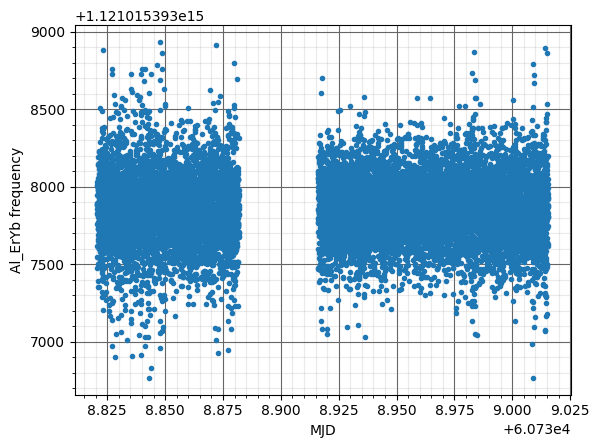

429228004229872.5713514104946


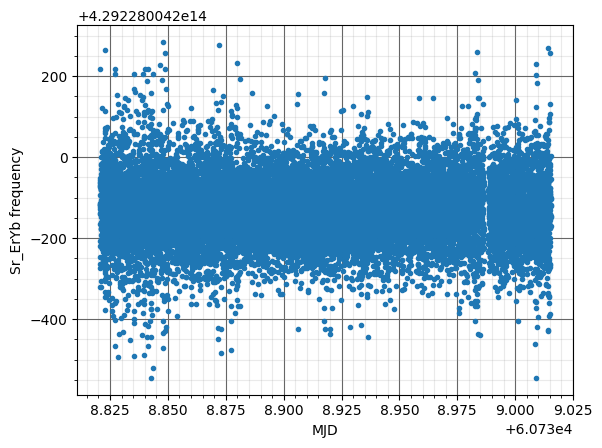

518295836590863.0284561723869


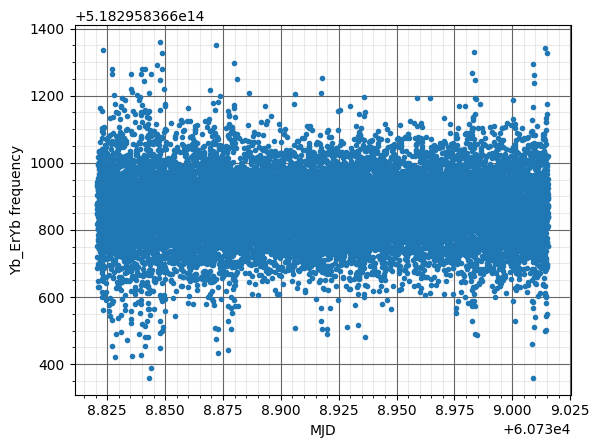

In [34]:
## Summarize individual clock series for Amanda 
Al_series = pd.Series(frequency_Al_ErYb)
print(np.nanmean(Al_series))
plt.figure()
plt.plot(comb["MJD"], Al_series, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("Al_ErYb frequency")
plt.show()

Sr_series = pd.Series(frequency_Sr_ErYb)
print(np.nanmean(Sr_series))
plt.figure()
plt.plot(comb["MJD"], Sr_series, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("Sr_ErYb frequency")
plt.show()

Yb_series = pd.Series(frequency_Yb_ErYb)
print(np.nanmean(Yb_series))
plt.figure()
plt.plot(comb["MJD"], Yb_series, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("Yb_ErYb frequency")
plt.show()

Al+/Sr ratio offset from BACON paper -1.1975E-16
AVAR tau=5:  1.772292068348660528433653481E-33
AVAR tau=500:  4.086179555320394277385357126E-34


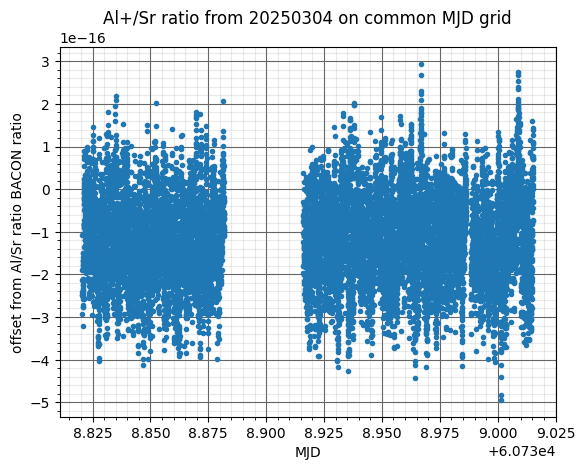

In [91]:
################################################################################
#######################  Plotting and Summarizing Ratios #######################
################################################################################
 
## Al/Sr ratio offset  
frequency_ratio_ErYb1 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Sr_ErYb)]

clean_frequency_ratio_ErYb1 = [
    x for x in frequency_ratio_ErYb1
    if x is not None
    and not (
        (isinstance(x, float) and math.isnan(x)) or
        (isinstance(x, Decimal) and x.is_nan())
    )
]

print("Al+/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1)) )
print("AVAR tau=5: ", overlapping_avar_fn(clean_frequency_ratio_ErYb1, 5))
print("AVAR tau=500: ", overlapping_avar_fn(clean_frequency_ratio_ErYb1, 500)) 


plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al+/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

Yb/Sr ratio offset from BACON paper 1.7728E-15
AVAR tau=5:  2.558025315424752409558496437E-33
AVAR tau=500:  5.370279065205084974144437743E-35


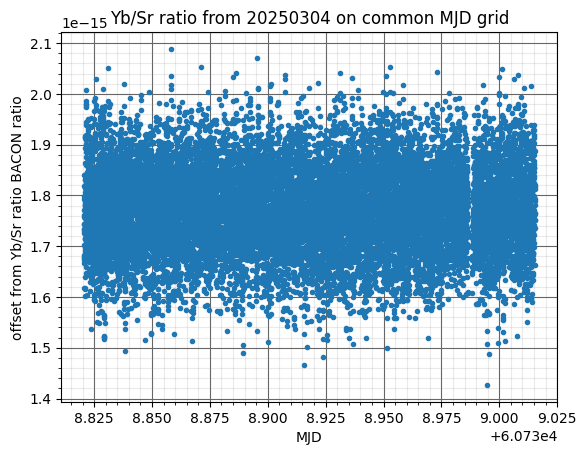

In [92]:
## Yb/Sr ratio offset  
frequency_ratio_ErYb2 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb, frequency_Sr_ErYb)]
 
clean_frequency_ratio_ErYb2 = [
    x for x in frequency_ratio_ErYb2
    if x is not None
    and not (
        (isinstance(x, float) and math.isnan(x)) or
        (isinstance(x, Decimal) and x.is_nan())
    )
]

print("Yb/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2)) )
print("AVAR tau=5: ", overlapping_avar_fn(clean_frequency_ratio_ErYb2, 5))
print("AVAR tau=500: ", overlapping_avar_fn(clean_frequency_ratio_ErYb2, 500)) 

plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

Al+/Yb ratio offset from BACON paper -1.8923E-15
AVAR tau=5:  2.704933780513243343216612353E-33
AVAR tau=500:  4.028496609124213761161644962E-34


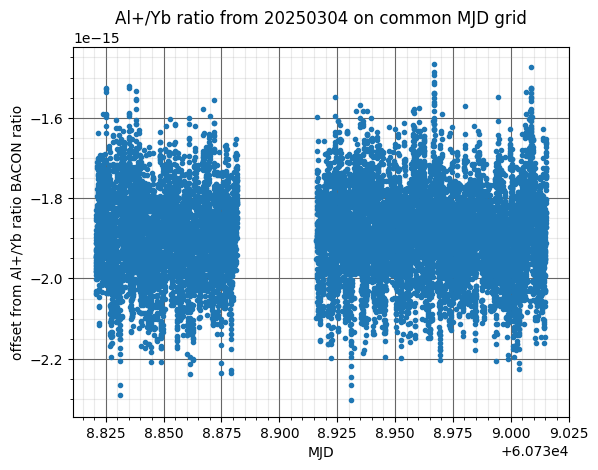

In [93]:
## Al/Yb ratio offset  
frequency_ratio_ErYb3 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Yb_ErYb)]
 
clean_frequency_ratio_ErYb3 = [
    x for x in frequency_ratio_ErYb3
    if x is not None
    and not (
        (isinstance(x, float) and math.isnan(x)) or
        (isinstance(x, Decimal) and x.is_nan())
    )
]

print("Al+/Yb ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3)) )
print("AVAR tau=5: ", overlapping_avar_fn(clean_frequency_ratio_ErYb3, 5))
print("AVAR tau=500: ", overlapping_avar_fn(clean_frequency_ratio_ErYb3, 500)) 

plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al+/Yb ratio BACON ratio")
plt.title("Al+/Yb ratio from " + days[day_index] + " on common MJD grid")
plt.show()


In [94]:

## Approach 1) found in pandas_interpolation_nick.py - effectively only performs 1d linear interpolation to match shift data to comb MJD
## shift_Al_tmp = shift_data_Al["shift"].interpolate(method="linear")  ##note this step is not necessary b/c of earlier filtering out "bad" shift data 
## shift_Sr_tmp = shift_data_Sr["shift"].interpolate(method="linear")
## shift_Yb_tmp = shift_data_Yb["shift"].interpolate(method="linear")

# shiftAl = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_Al_tmp)
# shiftSr = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_Sr_tmp)
# shiftYb = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_Yb_tmp)


## Approach 2) same as above except there's an additional interpolation step for missing vales in the comb data file
# nuAl = nuAl.interpolate(method = 'linear', limit = 10) 
# nuSr = nuSr.interpolate(method = 'linear', limit = 10)
# nuYb = nuYb.interpolate(method = 'linear', limit = 10)

# shiftAl = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_data_Al["shift"])
# shiftSr = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_data_Sr["shift"])
# shiftYb = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_data_Yb["shift"])

# ## Approach 3) Time series specific interpolation


# ## Outer join all shift data w/ comb values along MJD values, creating date-time index  
# comb_al_subset = comb[['MJD', 'nuAl']]
# al_subset = shift_data_Al.drop(columns=['IS_GOOD'])
# al_merged = pd.merge(comb_al_subset, al_subset, on="MJD", how="outer")
# timesAl = Time(al_merged['MJD'].values, format='mjd')
# datetime_index_Al = pd.DatetimeIndex(timesAl.to_datetime())
# al_merged.index = datetime_index_Al

# comb_sr_subset = comb[['MJD', 'nuSr']]
# sr_subset = shift_data_Sr.drop(columns=['IS_GOOD'])
# sr_merged = pd.merge(comb_sr_subset, sr_subset, on="MJD", how="outer")
# timesSr = Time(sr_merged['MJD'].values, format='mjd')
# datetime_index_Sr = pd.DatetimeIndex(timesSr.to_datetime())
# sr_merged.index = datetime_index_Sr

# comb_yb_subset = comb[['MJD', 'nuYb']]
# yb_subset = shift_data_Yb.drop(columns=['IS_GOOD'])
# yb_merged = pd.merge(comb_yb_subset, yb_subset, on="MJD", how="outer")
# timesYb = Time(yb_merged['MJD'].values, format='mjd')
# datetime_index_Yb = pd.DatetimeIndex(timesYb.to_datetime())
# yb_merged.index = datetime_index_Yb

# method_comb = 'time'
# method_shift = 'time'

# nuAl = al_merged['nuAl'].interpolate(method=method_comb, limit=10)
# shiftAl = al_merged['shift'].interpolate(method=method_shift, limit=10)

# nuSr = sr_merged['nuSr'].interpolate(method=method_comb, limit=10)
# shiftSr = sr_merged['shift'].interpolate(method=method_shift, limit=10)

# nuYb = yb_merged['nuYb'].interpolate(method=method_comb, limit=10)
# shiftYb = yb_merged['shift'].interpolate(method=method_shift, limit=10)


## Approach 4 - interpolate all missing values before finding overlapping window and then aligning series 
# Interpolate missing comb data https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
# methods include: linear (which treats values as equally spaced), time (requires additional processing to datetime format), pad (depreciated use different function), nearest, polynomial (must specify an order) 
# nuAl = comb['nuAl'].interpolate(method = 'nearest') 
# nuSr = comb['nuSr'].interpolate(method = 'nearest')
# nuYb = comb['nuYb'].interpolate(method = 'nearest')
# Align shift data with comb MJD grid (Q - what happens w/ missing data?) https://numpy.org/doc/2.2/reference/generated/numpy.interp.html
# specifically helps w/ alignment b/c input requires coordinates at which to evaluate interpolated values, no method option (only linear) 
# scipy.interpolate.interp1d is an alternative that permits different methods (but no time based method) 
# To evaluate interpolated values at new time points using the "time" method in pandas, you should:
# 0. index all data frames w/ datetime object based on MJD values 
# 1. Combine the original time series and the new time points into a single DatetimeIndex.
# 2. Reindex the original data to include the new time points.
# 3. Use .interpolate(method="time") to fill the missing values — this will include the new time points.
# Step 0: 
# Step 1: Combine original and new times, Use difference() to exclude overlapping time points from the union
#   all_times = ts.index.union(new_times).sort_values()
# Step 2: Reindex the series
#   ts_reindexed = ts.reindex(all_times)
# Step 3: Interpolate using method='time'
#   ts_interp = ts_reindexed.interpolate(method='time')

# timesComb = Time(comb['MJD'].values, format='mjd')
# datetime_index_comb = pd.DatetimeIndex(timesComb.to_datetime())


# interp_times_Al = comb.index.difference(shift_data_Al_datetime.index)
# #print(interp_times_Al)
# #print(shift_data_Al_datetime.index)

# all_times_Al = shift_data_Al_datetime.index.union(interp_times_Al).sort_values()
# Al_reindexed = shift_data_Al_datetime.reindex(all_times_Al)
#Al_interp = Al_reindexed['shift'].interpolate(method='time')
#print(Al_interp)


